In [8]:
import numpy as np
import fitsio as fio
import matplotlib.pyplot as plt
import galsim as galsim

In [9]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_fmasked.fits')[-1] # Central galaxy catalog
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_fmasked.fits')[-1] # Satellite galaxy catalog
clus_pa = fio.FITS('/lsst/troxel/y1a1/lgt20_clus_ang_2mom.fits')[-1] # Cluster position angle array

In [10]:
s = 10 # size of cutout (s by s square) in arcminutes
pixel_scale = 10 # size of pixel in arcseconds

In [11]:
sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
clus_n = len(sat_id_unq)
sat_max = np.amax(counts)

In [12]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    sat_prop_full = sat[prop].read()
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [13]:
# Read in values
cent_ra = np.deg2rad(cent['RA'].read().reshape((clus_n, -1)))
cent_dec = np.deg2rad(cent['DEC'].read().reshape((clus_n, -1)))
sat_ra = np.deg2rad(sat_prop('RA'))
sat_dec = np.deg2rad(sat_prop('DEC'))
clus_ang = clus_pa.read().reshape((clus_n, -1))

In [14]:
# Calculate satellite angular position for all clusters
def sat_ang_pos():
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [15]:
def mom_2(p, x, y, a, b):
    mom_top = p*a*b/(x**2+y**2)
    mom_sum = np.sum(np.nan_to_num(mom_top))/np.sum(np.nan_to_num(p))
    
    return mom_sum

In [16]:
def clus_pa():
    sat_ang = sat_ang_pos()
    p_i = sat_prop('P') * sat_prop('PFREE')
    x_i = sat_prop('R') * np.cos(sat_ang)
    y_i = sat_prop('R') * np.sin(sat_ang)
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    beta = np.arctan2(2*m_xy, (m_xx-m_yy)) / 2
    
    return m_xx, m_xy, m_yy, beta

In [17]:
xx, xy, yy, pa = clus_pa()

In [18]:
e1 = xx - yy
e2 = 2*xy

In [19]:
e1, e2

(-0.0014023127233585564, 0.0026461645307308103)

In [20]:
e_mag = np.sqrt(e1**2 + e2**2)

In [21]:
e_mag

0.002994773396734902

In [22]:
np.rad2deg(pa)

58.96048917533365

In [23]:
# Adjust RA values to be close to zero
cent_ra_mask = cent_ra > np.pi
cent_ra[cent_ra_mask] -= 2 * np.pi
sat_nan_mask = np.isnan(sat_ra)
sat_ra[sat_nan_mask] = -999
sat_ra_mask = sat_ra > np.pi
sat_ra[sat_ra_mask] -= 2 * np.pi
sat_ra[sat_ra==-999] = np.nan

In [24]:
# Compute sin and cos of angles for rotation
sin_neg = np.sin(-clus_ang)
cos_neg = np.cos(-clus_ang)

In [25]:
# Compute satellite distance from central
y = (sat_ra - cent_ra) * np.cos(cent_dec)
x = sat_dec - cent_dec

In [26]:
# Rotate satellites about centrals so major axis is at 0
dec_rot = cos_neg * x - sin_neg * y
ra_rot = sin_neg * x + cos_neg * y

In [27]:
# Mask nans from rotated RA/Dec values
ra_nan_mask = ~np.isnan(ra_rot)
ra_rot = ra_rot[ra_nan_mask]
dec_nan_mask = ~np.isnan(dec_rot)
dec_rot = dec_rot[dec_nan_mask]

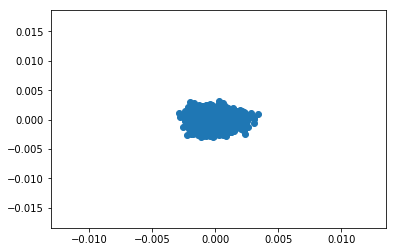

In [28]:
# Plot stacked satellites
plt.scatter(ra_rot, dec_rot)
plt.show()

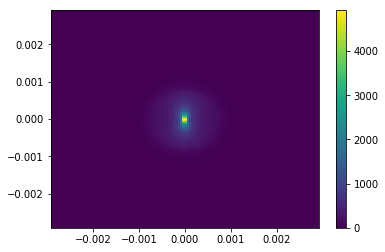

In [29]:
# Create 2d histogram
h, xedges, yedges, image = plt.hist2d(ra_rot, dec_rot, bins=2*s*60//pixel_scale, range=[[np.deg2rad(-s/60), np.deg2rad(s/60)], [np.deg2rad(-s/60), np.deg2rad(s/60)]])
plt.colorbar()
plt.show()

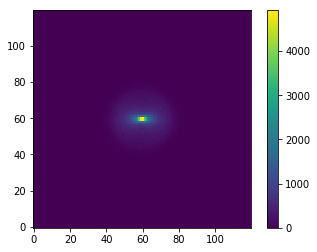

In [30]:
# Show histogram as image
plt.imshow(h, origin='lower')
plt.colorbar()
plt.show()

In [31]:
#log_h = h
#h_mask = log_h > 0
#log_h[h_mask] = np.log(log_h[h_mask])

In [32]:
def measure_shape_moments(img_array, pixel_scale):

    BAD_MEASUREMENT = 1
    CENTROID_SHIFT  = 2
    MAX_CENTROID_SHIFT = 1.

    out = np.zeros(1,dtype=[('e1','f4')]+[('e2','f4')]+[('T','f4')]+[('dx','f4')]+[('dy','f4')]+[('flag','i2')])

    M = e1 = e2 = 0
    im = galsim.Image(img_array, xmin=1, ymin=1, wcs=galsim.PixelScale(pixel_scale))

    try:
        shape_data = im.FindAdaptiveMom(weight=None, strict=False)
    except:
        out['flag'] |= BAD_MEASUREMENT
        return out

    if shape_data.moments_status != 0:
        out['flag'] |= BAD_MEASUREMENT
        return out

    out['dx'] = shape_data.moments_centroid.x - im.true_center.x
    out['dy'] = shape_data.moments_centroid.y - im.true_center.y
    if out['dx']**2 + out['dy']**2 > MAX_CENTROID_SHIFT**2:
        out['flag'] |= CENTROID_SHIFT
        return out

    # Account for the image wcs
    if im.wcs.isPixelScale():
        out['e1'] = shape_data.observed_shape.g1
        out['e2'] = shape_data.observed_shape.g2
        out['T']  = 2 * shape_data.moments_sigma**2 * im.scale**2
    else:
        e1    = shape_data.observed_shape.e1
        e2    = shape_data.observed_shape.e2
        s     = shape_data.moments_sigma
        jac   = im.wcs.jacobian(im.true_center)
        M     = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J     = jac.getMatrix()
        M     = J * M * J.T
        scale = np.sqrt(M/2./s/s)
        e1    = old_div((M[0,0] - M[1,1]), (M[0,0] + M[1,1]))
        e2    = old_div((2.*M[0,1]), (M[0,0] + M[1,1]))
        shear = galsim.Shear(e1=e1, e2=e2)
        out['T']  = M[0,0] + M[1,1]
        out['e1'] = shear.g1
        out['e2'] = shear.g2

    return out, shape_data

In [33]:
out, shape_data = measure_shape_moments(h, pixel_scale)

In [34]:
out

array([(0.34830585, 0.00043398, 4167.1885, -0.00766213, 0.01404758, 0)],
      dtype=[('e1', '<f4'), ('e2', '<f4'), ('T', '<f4'), ('dx', '<f4'), ('dy', '<f4'), ('flag', '<i2')])

In [35]:
np.sqrt(out[0][0]**2 + out[0][1]**2)

0.3483061215852096

In [36]:
np.rad2deg(shape_data.observed_shape.beta.rad)

0.03569452854372636

In [37]:
g = shape_data.observed_shape.g

In [38]:
((1-g)/(1+g))

0.48334266797559494